# Speed comparison of different tensors

## Imports

In [1]:
%pylab inline
import sys
sys.path.insert(0, '../')
import numpy as np
import pyopencl as cl
# import tensors
from lightgrad.autograd import Gradients
from lightgrad.autograd import CpuTensor
from lightgrad.autograd import OpenCLTensor, OpenCLDevice
# helpers
from timeit import timeit
from tqdm.notebook import tqdm
# opencl device
d = OpenCLDevice.any(cl.device_type.GPU)
d.ctx

Populating the interactive namespace from numpy and matplotlib


<pyopencl.Context at 0x24194345d30 on <pyopencl.Device 'GeForce GPU' on 'NVIDIA CUDA' at 0x24195a4e350>>

## Helpers

In [2]:
def plot_time_series(title_, sizes, **named_series):
    figsize(8, 4)
    figure()
    title(title_)
    for name, series in named_series.items():
        plot(sizes, series, label=name)
    legend()
    xlabel("Number of Elements")
    ylabel("Time in s")
    show()

# Unary Operators

In [3]:
# tensor shapes
sizes = np.linspace(16, 512**2, num=30).astype(np.int32)
# create tensors
a_numpy = np.random.uniform(-1, 1, size=sizes.max()).astype(np.float32)
a_cpu = CpuTensor.from_numpy(a_numpy)
a_opencl = OpenCLTensor.from_numpy(a_numpy, device=d)

## Forward
There are these weird peeks which i have no idea where they come from. 

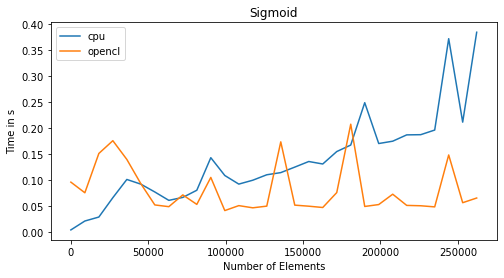

In [4]:
cpu_times, opencl_times = [], []
# pre-compile
a_opencl.relu()
# timing loop    
for s in tqdm(sizes):
    # get sub-tensors
    a_cpu_sub, a_opencl_sub = a_cpu[:s], a_opencl[:s]
    # timeit
    with Gradients.no_grad():
        cpu_times.append(timeit("a_cpu_sub.sigmoid()", globals=globals(), number=100))
        opencl_times.append(timeit("a_opencl_sub.sigmoid()", globals=globals(), number=100))
# plot
plot_time_series("Sigmoid", sizes, cpu=cpu_times, opencl=opencl_times)

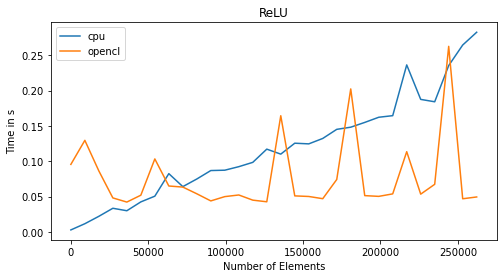

In [5]:
cpu_times, opencl_times = [], []
# pre-compile
a_opencl.relu()
# timing loop    
for s in tqdm(sizes):
    # get sub-tensors
    a_cpu_sub, a_opencl_sub = a_cpu[:s], a_opencl[:s]
    # timeit
    with Gradients.no_grad():
        cpu_times.append(timeit("a_cpu_sub.relu()", globals=globals(), number=100))
        opencl_times.append(timeit("a_opencl_sub.relu()", globals=globals(), number=100))
# plot
plot_time_series("ReLU", sizes, cpu=cpu_times, opencl=opencl_times)

## Backward

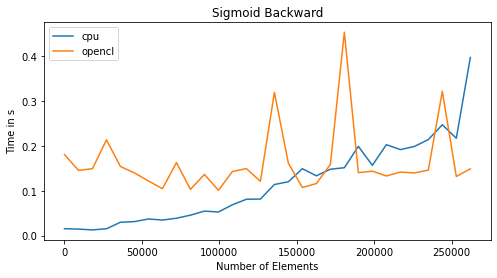

In [6]:
cpu_times, opencl_times = [], []
# pre-compile
a_opencl.sigmoid().backward(True)
# timing loop    
for s in tqdm(sizes):
    # get sub-tensors
    a_cpu_sub = a_cpu[:s].detach().sigmoid()
    a_opencl_sub = a_opencl[:s].detach().sigmoid()
    # timeit
    cpu_times.append(timeit("a_cpu_sub.backward(True)", globals=globals(), number=100))
    opencl_times.append(timeit("a_opencl_sub.backward(True)", globals=globals(), number=100))
# plot
plot_time_series("Sigmoid Backward", sizes, cpu=cpu_times, opencl=opencl_times)

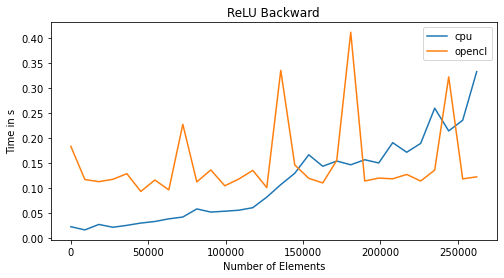

In [7]:
cpu_times, opencl_times = [], []
# pre-compile
a_opencl.relu().backward(True)
# timing loop    
for s in tqdm(sizes):
    # get sub-tensors
    a_cpu_sub = a_cpu[:s].detach().relu()
    a_opencl_sub = a_opencl[:s].detach().relu()
    # timeit
    cpu_times.append(timeit("a_cpu_sub.backward(True)", globals=globals(), number=100))
    opencl_times.append(timeit("a_opencl_sub.backward(True)", globals=globals(), number=100))
# plot
plot_time_series("ReLU Backward", sizes, cpu=cpu_times, opencl=opencl_times)

# Binary Operators

In [8]:
sizes = np.linspace(32, 1024, num=30).astype(np.int32) # actually will be squarred
# create tensors
a_numpy = np.random.uniform(-1, 1, size=[sizes.max()]*2).astype(np.float32)
b_numpy = np.random.uniform(-1, 1, size=[sizes.max()]*2).astype(np.float32)
a_cpu = CpuTensor.from_numpy(a_numpy)
b_cpu = CpuTensor.from_numpy(b_numpy)
a_opencl = OpenCLTensor.from_numpy(a_numpy, device=d)
b_opencl = OpenCLTensor.from_numpy(b_numpy, device=d)

## Forward
Also tracking timeing of addition with tranposed. Transposition leads to different strides in A and B which slows down the data accesses for the kernel.

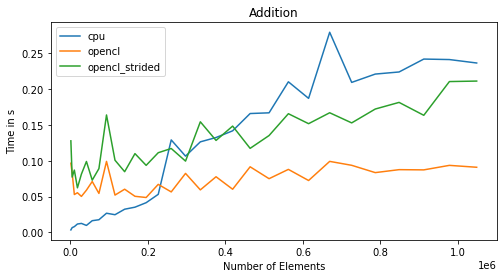

In [9]:
cpu_times, opencl_times, opencl_t_times = [], [], []
# pre-compile
a_opencl + b_opencl
# timing loop    
for s in tqdm(sizes):
    # get sub-tensors
    a_cpu_sub, a_opencl_sub = a_cpu[:s, :s], a_opencl[:s, :s]
    b_cpu_sub, b_opencl_sub = b_cpu[:s, :s], b_opencl[:s, :s]
    b_opencl_sub_t = b_opencl_sub.transpose(1, 0)
    # timeit
    with Gradients.no_grad():
        cpu_times.append(timeit("a_cpu_sub + b_cpu_sub", globals=globals(), number=100))
        opencl_times.append(timeit("a_opencl_sub + b_opencl_sub", globals=globals(), number=100))
        opencl_t_times.append(timeit("a_opencl_sub + b_opencl_sub_t", globals=globals(), number=100))
# plot
plot_time_series("Addition", sizes**2, cpu=cpu_times, opencl=opencl_times, opencl_strided=opencl_t_times)

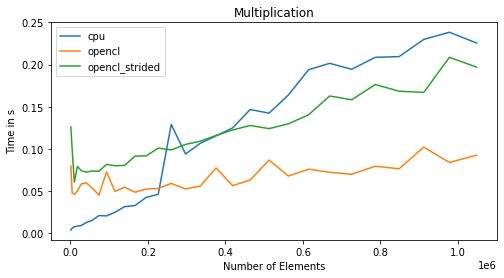

In [10]:
cpu_times, opencl_times, opencl_t_times = [], [], []
# pre-compile
a_opencl * b_opencl
# timing loop    
for s in tqdm(sizes):
    # get sub-tensors
    a_cpu_sub, a_opencl_sub = a_cpu[:s, :s], a_opencl[:s, :s]
    b_cpu_sub, b_opencl_sub = b_cpu[:s, :s], b_opencl[:s, :s]
    b_opencl_sub_t = b_opencl_sub.transpose(1, 0)
    # timeit
    with Gradients.no_grad():
        cpu_times.append(timeit("a_cpu_sub * b_cpu_sub", globals=globals(), number=100))
        opencl_times.append(timeit("a_opencl_sub * b_opencl_sub", globals=globals(), number=100))
        opencl_t_times.append(timeit("a_opencl_sub * b_opencl_sub_t", globals=globals(), number=100))
# plot
plot_time_series("Multiplication", sizes**2, cpu=cpu_times, opencl=opencl_times, opencl_strided=opencl_t_times)

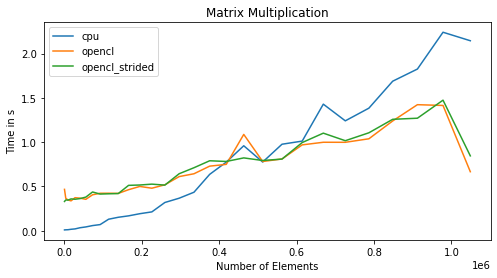

In [11]:
cpu_times, opencl_times, opencl_t_times = [], [], []
# pre-compile
a_opencl @ b_opencl
# timing loop    
for s in tqdm(sizes):
    # get sub-tensors
    a_cpu_sub, a_opencl_sub = a_cpu[:s, :s], a_opencl[:s, :s]
    b_cpu_sub, b_opencl_sub = b_cpu[:s, :s], b_opencl[:s, :s]
    b_opencl_sub_t = b_opencl_sub.transpose(1, 0)
    # timeit
    with Gradients.no_grad():
        cpu_times.append(timeit("a_cpu_sub @ b_cpu_sub", globals=globals(), number=100))
        opencl_times.append(timeit("a_opencl_sub @ b_opencl_sub", globals=globals(), number=100))
        opencl_t_times.append(timeit("a_opencl_sub @ b_opencl_sub_t", globals=globals(), number=100))
# plot
plot_time_series("Matrix Multiplication", sizes**2, cpu=cpu_times, opencl=opencl_times, opencl_strided=opencl_t_times)

## Backward

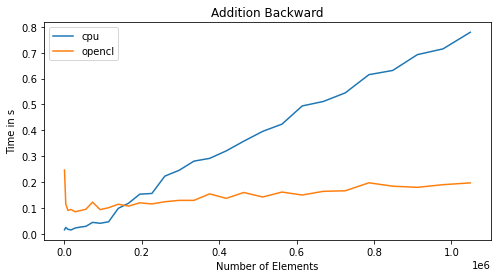

In [12]:
cpu_times, opencl_times = [], []
# pre-compile
(a_opencl + b_opencl).backward(True)
# timing loop    
for s in tqdm(sizes):
    # get sub-tensors
    r_cpu = a_cpu[:s, :s].detach() + b_cpu[:s, :s].detach()
    r_opencl = a_opencl[:s, :s].detach() + b_opencl[:s, :s].detach()
    # timeit
    cpu_times.append(timeit("r_cpu.backward(True)", globals=globals(), number=100))
    opencl_times.append(timeit("r_opencl.backward(True)", globals=globals(), number=100))
# plot
plot_time_series("Addition Backward", sizes**2, cpu=cpu_times, opencl=opencl_times)

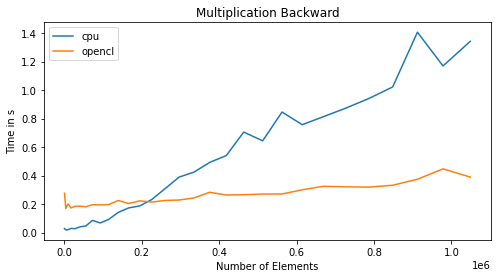

In [13]:
cpu_times, opencl_times = [], []
# pre-compile
(a_opencl * b_opencl).backward(True)
# timing loop    
for s in tqdm(sizes):
    # get sub-tensors
    r_cpu = a_cpu[:s, :s].detach() * b_cpu[:s, :s].detach()
    r_opencl = a_opencl[:s, :s].detach() * b_opencl[:s, :s].detach()
    # timeit
    cpu_times.append(timeit("r_cpu.backward(True)", globals=globals(), number=100))
    opencl_times.append(timeit("r_opencl.backward(True)", globals=globals(), number=100))
# plot
plot_time_series("Multiplication Backward", sizes**2, cpu=cpu_times, opencl=opencl_times)

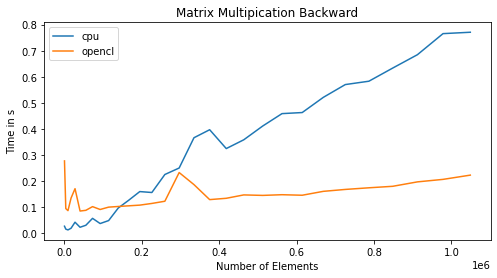

In [14]:
cpu_times, opencl_times = [], []
# pre-compile
(a_opencl @ b_opencl).backward(True)
# timing loop    
for s in tqdm(sizes):
    # get sub-tensors
    r_cpu = a_cpu[:s, :s].detach() + b_cpu[:s, :s].detach()
    r_opencl = a_opencl[:s, :s].detach() + b_opencl[:s, :s].detach()
    # timeit
    cpu_times.append(timeit("r_cpu.backward(True)", globals=globals(), number=100))
    opencl_times.append(timeit("r_opencl.backward(True)", globals=globals(), number=100))
# plot
plot_time_series("Matrix Multipication Backward", sizes**2, cpu=cpu_times, opencl=opencl_times)

# Reductions

In [15]:
sizes = np.linspace(32, 4096, num=15).astype(np.int32) # actually will be squarred
# create tensors
a_numpy = np.random.uniform(-1, 1, size=[sizes.max()]*2).astype(np.float32)
a_cpu = CpuTensor.from_numpy(a_numpy)
a_opencl = OpenCLTensor.from_numpy(a_numpy, device=d)

## Forward
Also tracking time for summation over specific axis. This shows the influence of non-coalescent accesses to global memory.
The Reduction Kernel could really use some improvement!

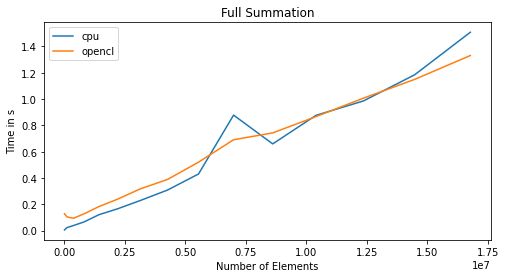

In [16]:
cpu_times, opencl_times = [], []
# pre-compile
a_opencl.sum()
# timing loop    
for s in tqdm(sizes):
    # get sub-tensors
    a_cpu_sub, a_opencl_sub = a_cpu[:s, :s], a_opencl[:s, :s]
    # timeit
    cpu_times.append(timeit("a_cpu_sub.sum()", globals=globals(), number=100))
    opencl_times.append(timeit("a_opencl_sub.sum()", globals=globals(), number=100))
# plot
plot_time_series("Full Summation", sizes**2, cpu=cpu_times, opencl=opencl_times)

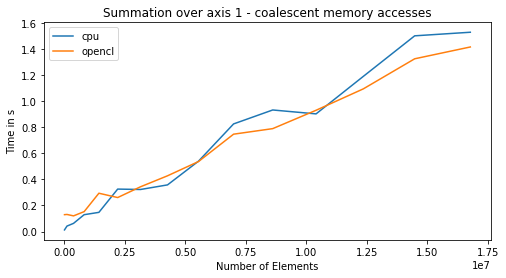

In [17]:
cpu_times, opencl_times = [], []
# pre-compile
a_opencl.sum()
# timing loop    
for s in tqdm(sizes):
    # get sub-tensors
    a_cpu_sub, a_opencl_sub = a_cpu[:s, :s], a_opencl[:s, :s]
    # timeit
    cpu_times.append(timeit("a_cpu_sub.sum(axis=1)", globals=globals(), number=100))
    opencl_times.append(timeit("a_opencl_sub.sum(axis=1)", globals=globals(), number=100))
# plot
plot_time_series("Summation over axis 1 - coalescent memory accesses", sizes**2, cpu=cpu_times, opencl=opencl_times)

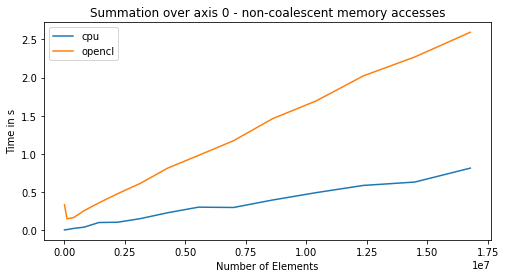

In [18]:
cpu_times, opencl_times = [], []
# pre-compile
a_opencl.sum()
# timing loop    
for s in tqdm(sizes):
    # get sub-tensors
    a_cpu_sub, a_opencl_sub = a_cpu[:s, :s], a_opencl[:s, :s]
    # timeit
    cpu_times.append(timeit("a_cpu_sub.sum(axis=0)", globals=globals(), number=100))
    opencl_times.append(timeit("a_opencl_sub.sum(axis=0)", globals=globals(), number=100))
# plot
plot_time_series("Summation over axis 0 - non-coalescent memory accesses", sizes**2, cpu=cpu_times, opencl=opencl_times)